# Simple RL Experiment
A notebook to experiment with a simple reinforcement learning problem: get through a 3x3 maze. The maze in a possible starting state looks like this:

|1|0|0|
|-|-|-|
|0|2|0|
|0|0|4|

The number in each cell indicates:

|number|meaning|
|--|--|
|0|open space|
|1|current position|
|2|hole (losing position)|
|4|goal (winning position)|
|3|current position = hole|
|5|current position = goal|

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [9]:
def get_states(board_size, hole_pos, goal_pos):
    def make_template():
        template = np.zeros(board_size)
        template[hole_pos] = 2
        template[goal_pos] = 4
        return template
    
    def make_state(template, curr_pos):
        template[curr_pos] = template[curr_pos] + 1
        return template
    return [make_state(make_template(), p) for p in np.ndindex(board_size)]

def get_curr_pos(state):
    return [p for p in np.ndindex(state.shape) if state[p] % 2 == 1][0]

def is_end_state(state):
    if state[get_curr_pos(state)] in [3, 5]:
        return True
    else:
        return False

def action_delta(action):
    pos_delta = (0, 0)
    if action == 'up':
        pos_delta = (-1, 0)    
    if action == 'down':
        pos_delta = (1, 0)    
    if action == 'left':
        pos_delta = (0, -1)    
    if action == 'right':
        pos_delta = (0, 1)  
    return pos_delta

def get_next_pos(state, action):
    return tuple(np.add(get_curr_pos(state), action_delta(action)))

def get_next_state(states, state, action):
    return [s for s in states if get_curr_pos(s) == get_next_pos(state, action)][0]

def get_possible_actions(actions, state):
    return [] if is_end_state(state) else [action for action in actions if get_next_pos(state, action) in np.ndindex(state.shape)]

def get_state_index(states, state):
    return [i for i, s in enumerate(states) if np.array_equal(s, state)][0]

def get_action_index(actions, action):
    return [i for i, a in enumerate(actions) if a == action][0]

def get_possible_qvalues(states, actions, state):
    possible_next_actions = [get_action_index(actions, a) for a in get_possible_actions(actions, state)]
    return np.take(qmatrix[get_state_index(states, state)], possible_next_actions)

def argmax(l):
    return [i for i, a in enumerate(l) if a == max(l)]

def get_best_action(qmatrix, states, actions, state):
    possible_next_actions = [get_action_index(actions, a) for a in get_possible_actions(actions, state)]
    return actions[possible_next_actions[np.random.choice(argmax(get_possible_qvalues(states, actions, state)))]]

def get_next_action(qmatrix, states, actions, state, rand_factor):
    if np.random.rand() <= rand_factor:
        return np.random.choice(get_possible_actions(actions, state))
    else:
        return get_best_action(qmatrix, states, actions, state)
    
def get_reward(state, num_moves):
    if state[get_curr_pos(state)] == 5:
        return 1.0 / num_moves
    else:
        return 0
        
def update_qmatrix(qmatrix, states, actions, num_moves, state, action):
    next_state = get_next_state(states, state, action)
    reward = get_reward(next_state, num_moves)
    possible_next_qvalues = get_possible_qvalues(states, actions, next_state)
    max_next_qvalues = 0 if len(possible_next_qvalues) == 0 else np.max(possible_next_qvalues)
    qmatrix[(get_state_index(states, state), get_action_index(actions, action))] = reward + 0.5 * max_next_qvalues
    return qmatrix
    
def run_game(states, actions, qmatrix, starting_state, starting_random_factor):
    curr_state = starting_state
    moves = []
    
    while(len(moves) < 20 and not is_end_state(curr_state)):
        action = get_next_action(qmatrix, states, actions, curr_state, starting_random_factor / (len(moves) + 1))
        qmatrix = update_qmatrix(qmatrix, states, actions, len(moves), curr_state, action)
        curr_state = get_next_state(states, curr_state, action)
        moves += [action]
    
    return {'num_moves': len(moves), 'final_reward': get_reward(curr_state, len(moves)), 'moves': moves, 'qmatrix': qmatrix}

def run_games(states, actions, qmatrix, starting_state, num_games):
    games = []
    
    while(len(games) < num_games):
        games += [run_game(states, actions, qmatrix, starting_state, 1 - 0.01 * len(games))]
        qmatrix = games[-1]['qmatrix']
    
    return games

In [10]:
states = get_states((3, 3), (1, 1), (2, 2))

In [11]:
actions = ['up', 'down', 'left', 'right']

In [56]:
qmatrix = 0.1 * np.random.randn(len(states), len(actions))

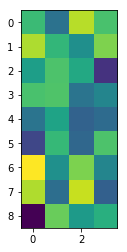

In [57]:
plt.imshow(qmatrix)

In [89]:
games = run_games(states, actions, qmatrix, states[0], 40)

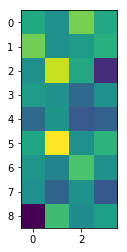

In [90]:
plt.imshow(games[-1]['qmatrix'])

In [91]:
states[6]

array([[ 0.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  0.,  4.]])

In [92]:
run_game(states, actions, games[-1]['qmatrix'], states[0], 0)

{'final_reward': 0.25,
 'moves': ['right', 'right', 'down', 'down'],
 'num_moves': 4,
 'qmatrix': array([[  4.30641657e-02,   4.46428571e-03,   1.18337401e-01,
           2.50000000e-02],
        [  1.13327581e-01,   0.00000000e+00,   2.08333333e-02,
           8.33333333e-02],
        [  3.99721884e-05,   1.00000000e-01,   4.16666667e-02,
          -1.47744668e-01],
        [  2.08333333e-02,   2.23214286e-03,  -6.20161798e-02,
           0.00000000e+00],
        [ -6.21273623e-02,   6.83902026e-03,  -8.79153232e-02,
          -7.58686675e-02],
        [  3.57142857e-02,   3.33333333e-01,   0.00000000e+00,
           5.78256746e-02],
        [  1.04166667e-02,  -2.01768946e-02,   8.73101324e-02,
           2.60416667e-03],
        [  0.00000000e+00,  -7.15046634e-02,   3.12500000e-03,
          -9.05892996e-02],
        [ -2.00389978e-01,   7.60987090e-02,  -5.37496321e-03,
           2.60476092e-02]])}